In [1]:
%matplotlib inline

import random
from functools import partial
import time

import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from dqnroute.utils import *
from dqnroute.networks import *

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('../src/pd.csv', index_col=0)

In [3]:
data.head()

,dst,src,pkg_id,nbr,amatrix_0,amatrix_1,amatrix_2,amatrix_3,amatrix_4,amatrix_5,...,amatrix_91,amatrix_92,amatrix_93,amatrix_94,amatrix_95,amatrix_96,amatrix_97,amatrix_98,amatrix_99,estim
0,9.0,7.0,0.0,6.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-57.236364
1,9.0,7.0,0.0,3.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-57.236364
2,9.0,7.0,0.0,5.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-28.618182
3,9.0,5.0,0.0,4.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-42.927273
4,9.0,5.0,0.0,7.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-42.927273


In [4]:
data.shape

(165293, 105)

In [5]:
def shuffle(df):
    return df.reindex(np.random.permutation(df.index))

In [15]:
class CachedEmbs:
    def __init__(self, InnerEmbs, dim):
        self.InnerEmbs = InnerEmbs
        self.dim = dim
        
        self.cache = {}
        
    def get_hash(self, amatrix):
        return hash(str(amatrix))
        
    def fit(self, amatrix):
        h = self.get_hash(amatrix)
        if h not in self.cache:
            embs = self.InnerEmbs(self.dim)
            embs.fit(amatrix)
            self.cache[h] = embs
    
    def encode(self, amatrix, nodes):
        h = self.get_hash(amatrix)
        return self.cache[h].encode(nodes)

In [21]:
# Итерация по батчам
def qnetwork_batches(addit_inputs, train_df, batch_size, embs):    
    amatrix_cols = [col for col in train_df if col.startswith('amatrix')]

    addit_cols = []
    for inp in addit_inputs:
        if inp['name'] == 'amatrix':
            addit_cols.extend(amatrix_cols)

    for start, end in make_batches(len(train_df), batch_size):
        st = time.time()

        batch_df = train_df[start:end]
        
        srcs, dsts, nbrs, addits = [], [], [], []
        
        for i in range(len(batch_df)):
            row = batch_df.iloc[i]
            amatrix = row[amatrix_cols].values
            embs.fit(amatrix)
            
            srcs.append(embs.encode(amatrix, row['src']))
            dsts.append(embs.encode(amatrix, row['dst']))
            nbrs.append(embs.encode(amatrix, row['nbr']))
            
            addit = row[addit_cols].values
            if len(addit):
                addits.append(addit)
        
        prep_batch = [
            np.array(srcs),
            np.array(dsts),
            np.array(nbrs)
        ]
        
        if len(addits):
            prep_batch.append(np.array(addits))
        
        targets = torch.tensor(batch_df['estim'].values, dtype=torch.float)
        
        print(time.time() - st)
        print(end)
        
        yield prep_batch, targets


# Эпоха с оптимизацией
def qnetwork_pretrain_epoch(model, optimizer, data, embs):
    loss_fn = nn.MSELoss()
    
    for batch, target in qnetwork_batches(model.addit_inputs, data, 64, embs):
        # Обнулить градиент, который накапливается во время обратного прохода
        optimizer.zero_grad()
        
        pred = model(*batch)
        loss = loss_fn(pred, target.unsqueeze(1))
        loss.backward()
        
        # Обновить параметры модели
        optimizer.step()
        
        yield float(loss)


# Итерация по эпохам
def qnetwork_pretrain(model,
                      data,
                      optim_name,
                      epoch_num,
                      embs,
                      need_save=True):
    optimizer = optim_class(optim_name)(model.parameters(), lr=0.001)
    
    epoch_losses = []
    for _ in range(epoch_num):
        loss_sum = 0
        loss_num = 0
        for loss in qnetwork_pretrain_epoch(model, optimizer, data, embs):
            loss_sum += loss
            loss_num += 1
            
        batch_loss = loss_sum / loss_num
        print(batch_loss)
        epoch_losses.append(batch_loss)
        
    if need_save:
        model.save()
    
    return epoch_losses

In [8]:
plt.rc('font', size=14)

def plot_losses(losses_dict,
                name,
                figsize=(13, 7),
                title=None):
    fig = plt.figure(figsize=figsize)
    
    for label, losses in losses_dict.items():
        X = list(range(1, len(losses)+1))
        plt.plot(X, losses, label=label)
    
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.xticks(X)
    plt.grid()
    plt.legend()
   
    if title is not None:
        plt.title(title)
        
    if name is not None:
        fig.savefig('../img/' + name, bbox_inches='tight')
    
    plt.show()

In [9]:
set_random_seed(40)

QNetworkAmatrix = partial(QNetwork, addit_inputs=[{'name': 'amatrix'}])

nodes_num = 10

## One-hot + adjacency matrix

In [23]:
model_am = QNetworkAmatrix(nodes_num,
                           [64, 64],
                           'relu',
                           {'name': 'oh'})

oh_embs = CachedEmbs(OHNodeEnc, dim=nodes_num)

In [24]:
losses_am = qnetwork_pretrain(model_am,
                              shuffle(data),
                              'rmsprop',
                              10,
                              oh_embs)

0.2216353416442871
64
0.29257893562316895
128
0.34377098083496094
192
0.27577877044677734
256
0.2666003704071045
320
0.22561335563659668
384
0.22594881057739258
448
0.22191953659057617
512
0.22185611724853516
576
0.2226238250732422
640
0.22904038429260254
704
0.23300814628601074
768
0.24471378326416016
832
0.23010969161987305
896
0.22872543334960938
960
0.2383270263671875
1024
0.23102593421936035
1088
0.23468279838562012
1152
0.23832011222839355
1216
0.25317859649658203
1280
0.2473294734954834
1344
0.2395343780517578
1408
0.25414228439331055
1472
0.24389910697937012
1536
0.2442162036895752
1600
0.23963665962219238
1664


KeyboardInterrupt: 

## Laplacian eigenmaps only

In [18]:
model_le = QNetwork(nodes_num,
                    [64, 64],
                    'relu',
                    {'name': 'le', 'dim': 4})

le_embs = CachedEmbs(LENodeEnc, dim=4)

In [19]:
data_full_graph = data[data['pkg_id'] < 5000]
data_full_graph.head()

,dst,src,pkg_id,nbr,amatrix_0,amatrix_1,amatrix_2,amatrix_3,amatrix_4,amatrix_5,...,amatrix_91,amatrix_92,amatrix_93,amatrix_94,amatrix_95,amatrix_96,amatrix_97,amatrix_98,amatrix_99,estim
0,9.0,7.0,0.0,6.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-57.236364
1,9.0,7.0,0.0,3.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-57.236364
2,9.0,7.0,0.0,5.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-28.618182
3,9.0,5.0,0.0,4.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-42.927273
4,9.0,5.0,0.0,7.0,0.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,-42.927273


In [22]:
print(model_le.label)
losses_le = qnetwork_pretrain(model_le,
                              shuffle(data),
                              'rmsprop',
                              10,
                              le_embs)

qnetwork_8_64-64_relu_le-4
0.22707676887512207
64
0.22087621688842773
128
0.2294149398803711
192
0.2567863464355469
256
0.23489069938659668
320
0.22260713577270508
384
0.22286415100097656
448
0.22499704360961914
512
0.3443734645843506
576
0.22268033027648926
640
0.22379279136657715
704
0.2248525619506836
768
0.2438185214996338
832
0.26540088653564453
896
0.2511889934539795
960
0.24010372161865234
1024
0.2453596591949463
1088
0.23447442054748535
1152
0.24126863479614258
1216


KeyboardInterrupt: 

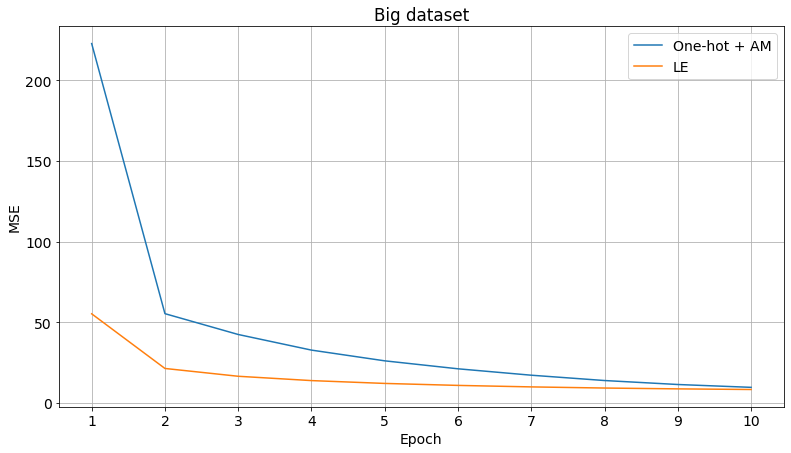

In [29]:
plot_losses({
    'One-hot + AM': losses_am,
    'LE': losses_le
}, #'foobar', title='Big dataset')